# Assignment 3: LDA Topic Modeling

## Note
Installing Tomotopy locally can return an error, if that's the case run this notebook on Google Colab

## Research Background

LDA is a popular topic modeling algorithm widely used in the fields of Digital Humanities and Social Sciences. In the field of political communication, topic modeling is often applied for analyzing politicians Twitter/X posts, identitying thematic patterns or topics revolving around their posts.

For this assignment, students will work with tweets from two USA politicians, Donald Trump and Bernie Sanders, who are often regarded as right-wing populist and left-wing populist respectively. Right-wing populism often emphasizes nationalism, anti-immigration policies, and a critique of global elites from a culturally conservative perspective, focusing on preserving traditional values and social hierarchies. Left-wing populism prioritizes economic inequality, advocating for the redistribution of wealth, expansion of social services, and empowerment of the working class against the capitalist elite. While both forms of populism appeal to the "common people" against perceived elites and established structures, they diverge significantly in their identification of the elites, proposed solutions, and core ideologies. For a more detailed explanation, you can read the chapter by Macaulay (2019) "Bernie and The Donald: A comparison of left-and right-wing populist discourse" (full reference below).

**Research Questions**
1. What topics are revolving around Donald Trump and Bernie Sanders' posts separately?
2. What are the topic differences between Trump (right-wing popoulist) and Sanders (left-wing populist)?

**Aim:**
1. The first aim of the assignment is to conduct LDA topic modeling. Identify thematic patterns or politics revolving around Trump or Sanders's posts.
2. The second aim is to critically evaluate the results of topic modeling. Try different numbers of topics to see with which settings the topics are more coherent. Critically reflect on the results of LDA topic modeling, discussing them in relation to existing theories about populism.

**Data**
Two datasets are prepared for this assginment. Tweets from Trump and tweets from Sanders. Students are asked to work on these two datasets.

**Methods**
1. Word segamentation
2. Removing stopwords
3. LDA topic modeling
4. Topic evaulation (coherence and human evaluation)
5. Visualization of results.

**References**
1. Macaulay, M. (2019). Bernie and the Donald: A comparison of Left-and Right-wing populist discourse. *Populist discourse: International perspectives*, 165-195.





## Setup

### Q1. Install necessary libraries, including `tomotopy` and `little_mallet_wrapper`, and import them

In [1]:
# Q1 (code)
# Install tomotopy and little_mallet_wrapper libraries
!pip install tomotopy
!pip install little_mallet_wrapper

In [2]:
# Import the two libraries
import tomotopy as tp
from little_mallet_wrapper import process_string, train_topic_model, plot_categories_by_topics_heatmap

## Data preprocessing

### Q2. Load the two datasets and concatenate them

The goal is to run topic modelling on the combined dataset of Sanders and Trump's tweets

In [3]:
# Q2 (code)
# Install and import Pandas
!pip install pandas
import pandas as pd

In [4]:
# Load the two datasets
trump_tweets = pd.read_csv(r'C:\Users\ASUS\Desktop\Assignment3-AD\trump_tweets.csv')
sanders_tweets = pd.read_csv(r'C:\Users\ASUS\Desktop\Assignment3-AD\sanders_tweets.csv')

In [5]:
trump_tweets['Politician'] = 'Trump'
sanders_tweets['Politician'] = 'Sanders'

# Use the pd.concat() function to concatenate the datasets
combined_tweets = pd.concat([trump_tweets, sanders_tweets]).reset_index(drop=True)
print(combined_tweets.head())

           Username             TweetId                                Title  \
0  @realDonaldTrump  822421390125043713  @realDonaldTrump_822421390125043713   
1  @realDonaldTrump  822501803615014918  @realDonaldTrump_822501803615014918   
2  @realDonaldTrump  822501939267141634  @realDonaldTrump_822501939267141634   
3  @realDonaldTrump  822502135233384448  @realDonaldTrump_822502135233384448   
4  @realDonaldTrump  822502270503972872  @realDonaldTrump_822502270503972872   

                                             Content Politician  
0   It all begins today! I will see you at 11:00 ...      Trump  
1   Today we are not merely transferring power fr...      Trump  
2   power from Washington, D.C. and giving it bac...      Trump  
3   What truly matters is not which party control...      Trump  
4   January 20th 2017, will be remembered as the ...      Trump  


### Q3. Clean the data

Transform all tweets to lowercase, remove stopwords, punctuation, and numbers. Add the processed text to a list called `training_data`.
Create a list with the content of the tweets (`original_texts`) and a list that allows you to identify both the author of the tweet and its ID (`titles`).


In [6]:
# Q3 (code)
# Install and import necessary libraries
! pip install nltk
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
#  Define a function to clean the tweets
def clean_tweet(tweet):
    stop_words = set(stopwords.words('english'))
    processed_text = tweet
    # Remove URLs, user mentions, and specific usernames
    processed_text = re.sub(r"http\S+|www\S+|https\S+|\/\/t\.co\/|\@\w+|#", '', processed_text, flags=re.MULTILINE)
    # Convert to lowercase
    processed_text = processed_text.lower()
    # Remove words like "rt" and "amp" 
    processed_text = re.sub(r'\brt\b|\bamp\b', '', processed_text)
    # Remove punctuation and numbers
    processed_text = re.sub(r'[“”‘’"\'\`]', '', processed_text)
    processed_text = re.sub(r'[^\w\s]', '', processed_text)
    # Tokenize
    tokens = word_tokenize(processed_text)
    # Remove stopwords
    filtered_tokens = [word for word in tokens if word not in stop_words]
    # Re-join the tokens into a string
    cleaned_tweet = ' '.join(filtered_tokens)
    return cleaned_tweet

In [15]:
# List to store cleaned tweet texts for LDA analysis.
training_data = [] 
# List to store cleaned tweet texts for LDA analysis.
original_texts = []  
# List to store identifiers for each tweet.
titles = []  

# Iterate over each row in the DataFrame `combined_tweets`
for index, row in combined_tweets.iterrows():
    cleaned_text = clean_tweet(row['Content'])
    # Add the cleaned tweet text to the `training_data` list.
    training_data.append(cleaned_text)
    # Add the original tweet text (before cleaning) to the `original_texts` list.
    original_texts.append(row['Content'])
    # Create a unique identifier for the tweet by concatenating the user's username
    titles.append(f"{row['Username']}_{row['TweetId']}")

In [17]:
# Check the first rows of processed texts
print(training_data[:5])
len(training_data),len(original_texts),len(titles)

['begins today see 1100 swearingin movement continues work begins', 'today merely transferring power one administration another one party another äì transferring', 'power washington dc giving back american people inaugurationday', 'truly matters party controls government whether government controlled people', 'january 20th 2017 remembered day people became rulers nation']


(30371, 30371, 30371)

## LDA topic modelling

### Q4. Train a an LDA topic model with `tomotopy`

In [18]:
# Q4 (code)
# Number of topics to return
num_topics = 15
# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

Topic Model Training...


Iteration: 0	Log-likelihood: -9.450124845450404
Iteration: 10	Log-likelihood: -9.038134360172922
Iteration: 20	Log-likelihood: -8.84775944943178
Iteration: 30	Log-likelihood: -8.743312022898602
Iteration: 40	Log-likelihood: -8.675595188139908
Iteration: 50	Log-likelihood: -8.632413900265263
Iteration: 60	Log-likelihood: -8.600659849063577
Iteration: 70	Log-likelihood: -8.573437072534183
Iteration: 80	Log-likelihood: -8.550162192165336
Iteration: 90	Log-likelihood: -8.5310904753624


### Q5. Print out the top words for each topic and manually evaluate their coherence


In [19]:
# Q5a (code)
# Print out top 10 words for each topic
print("\nTopic Model Results:\n\n")

topics = []
topic_individual_words = []
for topic_number in range(0, num_topics):
    topic_words = ' '.join(word for word, prob in model.get_topic_words(topic_id=topic_number, top_n=num_topic_words))
    topics.append(topic_words)
    topic_individual_words.append(topic_words.split())
    print(f"✨Topic {topic_number}✨\n\n{topic_words}\n")


Topic Model Results:


✨Topic 0✨

border great military strong total endorsement crime complete wall amendment

✨Topic 1✨

news fake media people would much even many like good

✨Topic 2✨

trump president biden joe years history economy ever best last

✨Topic 3✨

great new house white forward president thank book court good

✨Topic 4✨

election people vote trump votes voting states fraud court democracy

✨Topic 5✨

tax trump change climate security must people social cut republicans

✨Topic 6✨

states united us president war people iran korea world north

✨Topic 7✨

must people country wall law street american stand justice government

✨Topic 8✨

health care people workers million americans need right pay must

✨Topic 9✨

us china trade drug jobs dollars states deal big companies

✨Topic 10✨

president trump live coronavirus watch news new hurricane today state

✨Topic 11✨

democrats impeachment president house senate nothing dems never schiff call

✨Topic 12✨

fbi russia trump collus

# Q5b (words)
# Describe what each topic is about. What ideas, values, or situations do these keywords refer to?

✨Topic 0✨
Border security and crime: This topic focuses on border-related content and security, especially on the proposal to build a border wall and support for it.

✨Topic 1✨
Media criticism: This topic involves criticism of the media, especially the concept of "fake news", and questions about media bias and the quality of reporting.

✨Topic 2✨
President and achievement: This topic focuses on Trump and Biden's presidencies and economic policies. It may also contain comparisons and evaluations.

✨Topic 3✨
Political leadership and future policies: This topic includes positive perceptions of the White House, new policies, and outlook for the future. Keywords such as "great", "thanks" and "new" indicate optimism about political leadership and policy change.

✨Topic 4✨
Electoral integrity and political values: This topic involves the election process, voting behavior, allegations of fraud, and legal challenges, reflecting concerns and discussions about election integrity and political values.

✨Topic 5✨
Tax policy and climate change: This topic centers on tax policy, the need to encounter climate change, the social security system, and Republican policy positions. This could cover discussions on tax breaks, climate policy and social welfare.

✨Topic 6✨
International relations and global issues: This topic covers the U.S. role in the world, tensions with other countries (especially Iran and Korea), and international security.

✨Topic 7✨
National identity and social justice: This topic seems to explore various topics on national identity, law, social movements and governmental responsibility, reflecting values for the rule of law, democracy and social justice.

✨Topic 8✨
Health care and labor: This topic focuses on health care policy, workers' rights, economic inequality, and fair pay, suggesting concerns about equitable health care and working conditions.

✨Topic 9✨
Trade and economic development: The topic focuses on trade agreements, economic relations with China, job opportunities and economic development.

✨Topic 10✨
Emergency and public information: This topic includes keywords like "live", "coronavirus", "hurricane", suggesting real-time coverage of emergencies and public information dissemination.

✨Topic 11✨
Political confrontation and impeachment: This topic covers political rivalries, impeachment inquiries, and controversies within the legislature. It may be related to the Democrats, impeachment, and the dynamics with the House of Representatives and the Senate.

✨Topic 12✨
Investigation and political controversy: This topic unveals the Russia investigation and political intrigue. These words express perceptions of the survey, the people it focuses on, and politically hostile positions.

✨Topic 13✨
Society and culture: This topic focuses on American culture and society, including recognition of accomplishments, acknowledgements, honors, and celebrations of specific days. It may reflect public speaking, holiday celebrations, affirmation of America and its values, and special recognition of women.

✨Topic 14✨
Political activity and support: This topic emphasizes American greatness, election campaigns, and political support. The word " MAGA" suggests that this topic may be closely related to pro-Trump political activity.

## Topic coherence

Use `tomotopy`'s [`.coherence()`](https://bab2min.github.io/tomotopy/v0.10.0/en/coherence.html) function to automatically calculate the topic coherence.

The coherence value can vary from `0` (no coherence) to `1` (maximum coherence). Interpret the results and, if needed, retrain the model using a different number of topics.

In [20]:
# There are different metrics for coherence, we choose `c_v`

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

==== Coherence : c_v ====
Average: 0.5681618761022885 
Per Topic: [0.7433353722095489, 0.5688534617424011, 0.5124431908130646, 0.48867679536342623, 0.5200472444295883, 0.5571890860795975, 0.5516218945384026, 0.48493382930755613, 0.664656987786293, 0.5624561548233032, 0.41833106279373167, 0.6258236348628998, 0.7558715224266053, 0.5125573918223381, 0.555630512535572]



### Q6. Interpret topic coherence

Report the following:
- number of topics you initially used to train the model and the coherence score you got
- changes made to the number of topics and new coherence scores obtained

In [21]:
# When topic number is 10
num_topics = 10

# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.24336156312683
Iteration: 10	Log-likelihood: -8.885862721987387
Iteration: 20	Log-likelihood: -8.73351600291497
Iteration: 30	Log-likelihood: -8.662986123137498
Iteration: 40	Log-likelihood: -8.62082349316788
Iteration: 50	Log-likelihood: -8.592391745833734
Iteration: 60	Log-likelihood: -8.574693347651237
Iteration: 70	Log-likelihood: -8.55698688949804
Iteration: 80	Log-likelihood: -8.543342268325576
Iteration: 90	Log-likelihood: -8.533795592365939
==== Coherence : c_v ====
Average: 0.5704142814129591 
Per Topic: [0.49023019671440127, 0.6207201957702637, 0.5240671962499619, 0.5361851185560227, 0.5043413043022156, 0.4979054942727089, 0.6535689204931259, 0.5929761171340943, 0.6590212322771549, 0.625127038359642]



In [22]:
# When topic number is 20
num_topics = 20

# Numer of topic words to print out
num_topic_words = 10

# Create an LDA model instance
model = tp.LDAModel(k=num_topics)

# Add each document to the model, after splitting it up into words
for text in training_data:
    model.add_doc(text.strip().split())

print("Topic Model Training...\n\n")
# Iterate over the data 10 times
iterations = 10
for i in range(0, 100, iterations):
    model.train(iterations)
    print(f'Iteration: {i}\tLog-likelihood: {model.ll_per_word}')

coh = tp.coherence.Coherence(model, coherence='c_v')
average_coherence = coh.get_score()
coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]

print('==== Coherence : {} ===='.format('c_v'))
print('Average:', average_coherence, '\nPer Topic:', coherence_per_topic)
print()

Topic Model Training...


Iteration: 0	Log-likelihood: -9.505212088115274
Iteration: 10	Log-likelihood: -9.05217730856005
Iteration: 20	Log-likelihood: -8.862425452215819
Iteration: 30	Log-likelihood: -8.767948289736548
Iteration: 40	Log-likelihood: -8.708739931786946
Iteration: 50	Log-likelihood: -8.662017249257161
Iteration: 60	Log-likelihood: -8.62890640512124
Iteration: 70	Log-likelihood: -8.600031378541601
Iteration: 80	Log-likelihood: -8.575196761015206
Iteration: 90	Log-likelihood: -8.563968573171657
==== Coherence : c_v ====
Average: 0.5744695077463985 
Per Topic: [0.546285080909729, 0.5808328568935395, 0.4371828377246857, 0.7174615919589996, 0.6674301952123642, 0.5636407554149627, 0.4971500687301159, 0.5382779493927956, 0.5020353674888611, 0.5093442261219024, 0.4750413507223129, 0.5784042298793792, 0.8133973598480224, 0.5150173410773278, 0.5497717440128327, 0.695547929406166, 0.6350379139184952, 0.5339311227202416, 0.5443053603172302, 0.5892948731780052]



# Q6 (words)
· Initially 15 topics are used to train the model.The average coherence score for the model is about 0.568, suggesting that the topics are relatively coherent and meaningful.The highest coherence score for a single topic is about 0.756, indicating that this topic is very coherent and that the top words frequently appear. The lowest coherence score for a single topic is about 0.418, indicating that this topic is not so coherent and that the top words do not frequently appear. For most topics, the top-ranked words tend to appear together in the same document, suggesting that the model successfully captures meaningful patterns in the data corresponding to different topics.

· When the number of topics is increased, it may help the model to further segment these topics, making the new topics more relevant and clear. When the number of topics is decreased, it may prompt the model to merge similar topics, thus improving the overall consistency of the model.

### X1. Optional question 1
(This question is not compulsory, it only allows you to get an extra point.)

Create a function to plot the average coherence for models with different number of topics.

In [23]:
# X1 (code)
# Tip: y = average topic coherence; x = number of topics in the model
# Import necessary libraries for modeling and plotting
! pip install matplotlib
! pip install seaborn

In [24]:
import matplotlib.pyplot as plt
import tomotopy as tp
import seaborn as sns
import tomotopy as tp

Topics: 5, Average Coherence: 0.5291191396117211
Topics: 8, Average Coherence: 0.5280267243273555
Topics: 11, Average Coherence: 0.563507191836834
Topics: 14, Average Coherence: 0.5711519992245095
Topics: 17, Average Coherence: 0.6150067437933211
Topics: 20, Average Coherence: 0.6089363838359714


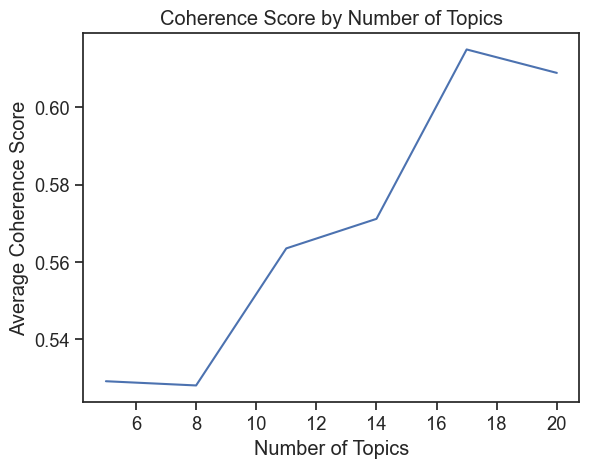

In [25]:
# Define a function to calculate the average consistency score for different topics
def calculate_average_coherence(texts, min_topics, max_topics, step):
    coherence_scores = []
    # Iterate over the number of topics within the specified range
    for k in range(min_topics, max_topics + 1, step):
        model = tp.LDAModel(k=k)
        # Add texts for the model
        for text in texts:
            model.add_doc(text.strip().split())
        # Train the model
        model.train(200) 
        # Calculate the coherence of the current model
        coh = tp.coherence.Coherence(model, coherence='c_v')
        average_coherence = coh.get_score()
        # Append the number of topics and the corresponding coherence score to the list
        coherence_scores.append((k, average_coherence))
        
        print(f"Topics: {k}, Average Coherence: {average_coherence}")
    # Return the list of coherence scores    
    return coherence_scores

# Execute the function to get coherence scores across different topic numbers
coherence_scores = calculate_average_coherence(training_data, 5, 20, 3)
# Unpack the list of tuples into two lists
topics, coherences = zip(*coherence_scores)

# Plot
plt.plot(topics, coherences)
plt.xlabel('Number of Topics')
plt.ylabel('Average Coherence Score')
plt.title('Coherence Score by Number of Topics')
plt.show()

### Q7. Topic distributions
Calculate the topic distributions for all tweets and get the top documents for some topics (between 2 and 5) that you think could be more representative of Sanders or Trump.

In [26]:
# Q7a (code)
topic_distributions = [list(doc.get_topic_dist()) for doc in model.docs]
import numpy as np

def get_top_docs_for_topic(topic_id, num_top_docs=5):
    # Extract the distribution for the specific topic across all documents
    topic_dists = np.array([dist[topic_id] for dist in topic_distributions])
    
    # Get the indices of the documents with the highest topic distributions
    top_doc_indices = topic_dists.argsort()[-num_top_docs:][::-1]
    
    # Return the top documents and their distributions for the topic
    return [(titles[idx], topic_dists[idx]) for idx in top_doc_indices]

for topic_id in range(2, 6): 
    top_docs = get_top_docs_for_topic(topic_id, 5)
    print(f"\nTop documents for Topic {topic_id}:")
    for doc in top_docs:
        print(f"Document Title: {doc[0]}, Distribution: {doc[1]}")


Top documents for Topic 2:
Document Title: @realDonaldTrump_1185375708559876098, Distribution: 0.8514660596847534
Document Title: @realDonaldTrump_1321053478622552066, Distribution: 0.8514660596847534
Document Title: @realDonaldTrump_1204539848582782977, Distribution: 0.8391397595405579
Document Title: @realDonaldTrump_1225273889204441088, Distribution: 0.8391397595405579
Document Title: @realDonaldTrump_854870777287634944, Distribution: 0.8391397595405579

Top documents for Topic 3:
Document Title: @realDonaldTrump_1210600561529237510, Distribution: 0.9320011138916016
Document Title: @realDonaldTrump_1025725493373558784, Distribution: 0.9320011138916016
Document Title: @realDonaldTrump_1226535948189675521, Distribution: 0.9320011138916016
Document Title: @realDonaldTrump_1044371304395276288, Distribution: 0.9320011138916016
Document Title: @realDonaldTrump_1251546384039378951, Distribution: 0.9295769333839417

Top documents for Topic 4:
Document Title: @realDonaldTrump_13402979071536

Interpret the results above. Are there topics that have top tweets only by one politician? Why do you think these topics are more representative of one of the two politicians' views?

# Q7b (words)
✨Topic 2✨
The top document for this topic only consists of tweets from Trump, suggesting that the tweets highly relevant to the topic are all from one political figure. This consistency may indicate that Topic 2 focuses on a topic or event specifically related to Trump. It can be speculated that this may involve Trump's personal political behavior, policy announcements, or reactions to his specific political issues.

✨Topic 3✨
The same as Topic 2, the top document for Topic 3 also only consists of Trump's tweets, suggesting that this topic may cover another area or event closely related to Trump. The highly concentrated distribution values indicate Trump's active engagement and influence on this topic.

✨Topic 4✨
In terms of this topic, the tweets come from two political figures, Trump and Sanders. This suggests that Topic 4 may cover a broader political or social topic that touches on the concerns of both political figures. Such concerns that cross political boundaries may include areas such as economic policy, public health, or social justice, areas in which both politicians may have spoken.

✨Topic 5✨
Topic 5 focuses on the intersection of fiscal policy with societal issues. It only consists of Trump's tweets, underscoring that certain themes may particularly reflect Trump's political stance or personal style.

The concentration of the most representative tweets under a topic on a single political figure may indicate that certain political issues or events are closely associated with particular politicians. Second, it may also reveal differences in social media strategies. A politician may be more inclined to speak out on certain issues or use a particular style of language to attract attention. Besides, this difference may reflect the interests of their supporters, where certain topics are more likely to attract the attention and engagement of one party.

## Large scale analysis

### Q8. Create a random sample of the whole dataset and visualize the topic distributions for the sampled tweets

In [31]:
! pip install --upgrade matplotlib seaborn

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
import tomotopy as tp

In [37]:
# Crete a sample of tweets
from random import sample
target_labels = sample(titles,100)

In [40]:
sns.set(style='ticks', font_scale=1.2)

def plot_categories_by_topics_heatmap(labels, topic_distributions, topic_keys, output_path=None, target_labels=None, color_map=sns.cm.rocket_r, dim=None):
    # Combine the labels and distributions into a list of dictionaries
    dicts_to_plot = []
    # Ensure the index scope of the topic keys
    max_topic_index = len(topic_keys) - 1
    for _label, _distribution in zip(labels, topic_distributions):
        if not target_labels or _label in target_labels:
            for _topic_index, _probability in enumerate(_distribution):
                if _topic_index > max_topic_index:
                    continue
                topic_description = ' '.join(topic_keys[_topic_index][:5])
                dicts_to_plot.append({'Probability': float(_probability),
                                      'Category': _label,
                                      'Topic': f'Topic {_topic_index:02}: {topic_description}'})

    # Create a dataframe, format it for the heatmap function, and normalize the columns
    df_to_plot = pd.DataFrame(dicts_to_plot)
    df_wide = df_to_plot.pivot_table(index='Category', columns='Topic', values='Probability')
    df_norm_col = (df_wide - df_wide.mean()) / df_wide.std()

    # Show the final plot
    if dim:
        plt.figure(figsize=dim)
    sns.set(style='ticks', font_scale=1.2)
    ax = sns.heatmap(df_norm_col, cmap=color_map)
    ax.xaxis.tick_top() 
    ax.xaxis.set_label_position('top')
    plt.xticks(rotation=30, ha='left')
    plt.tight_layout()
    plt.show()

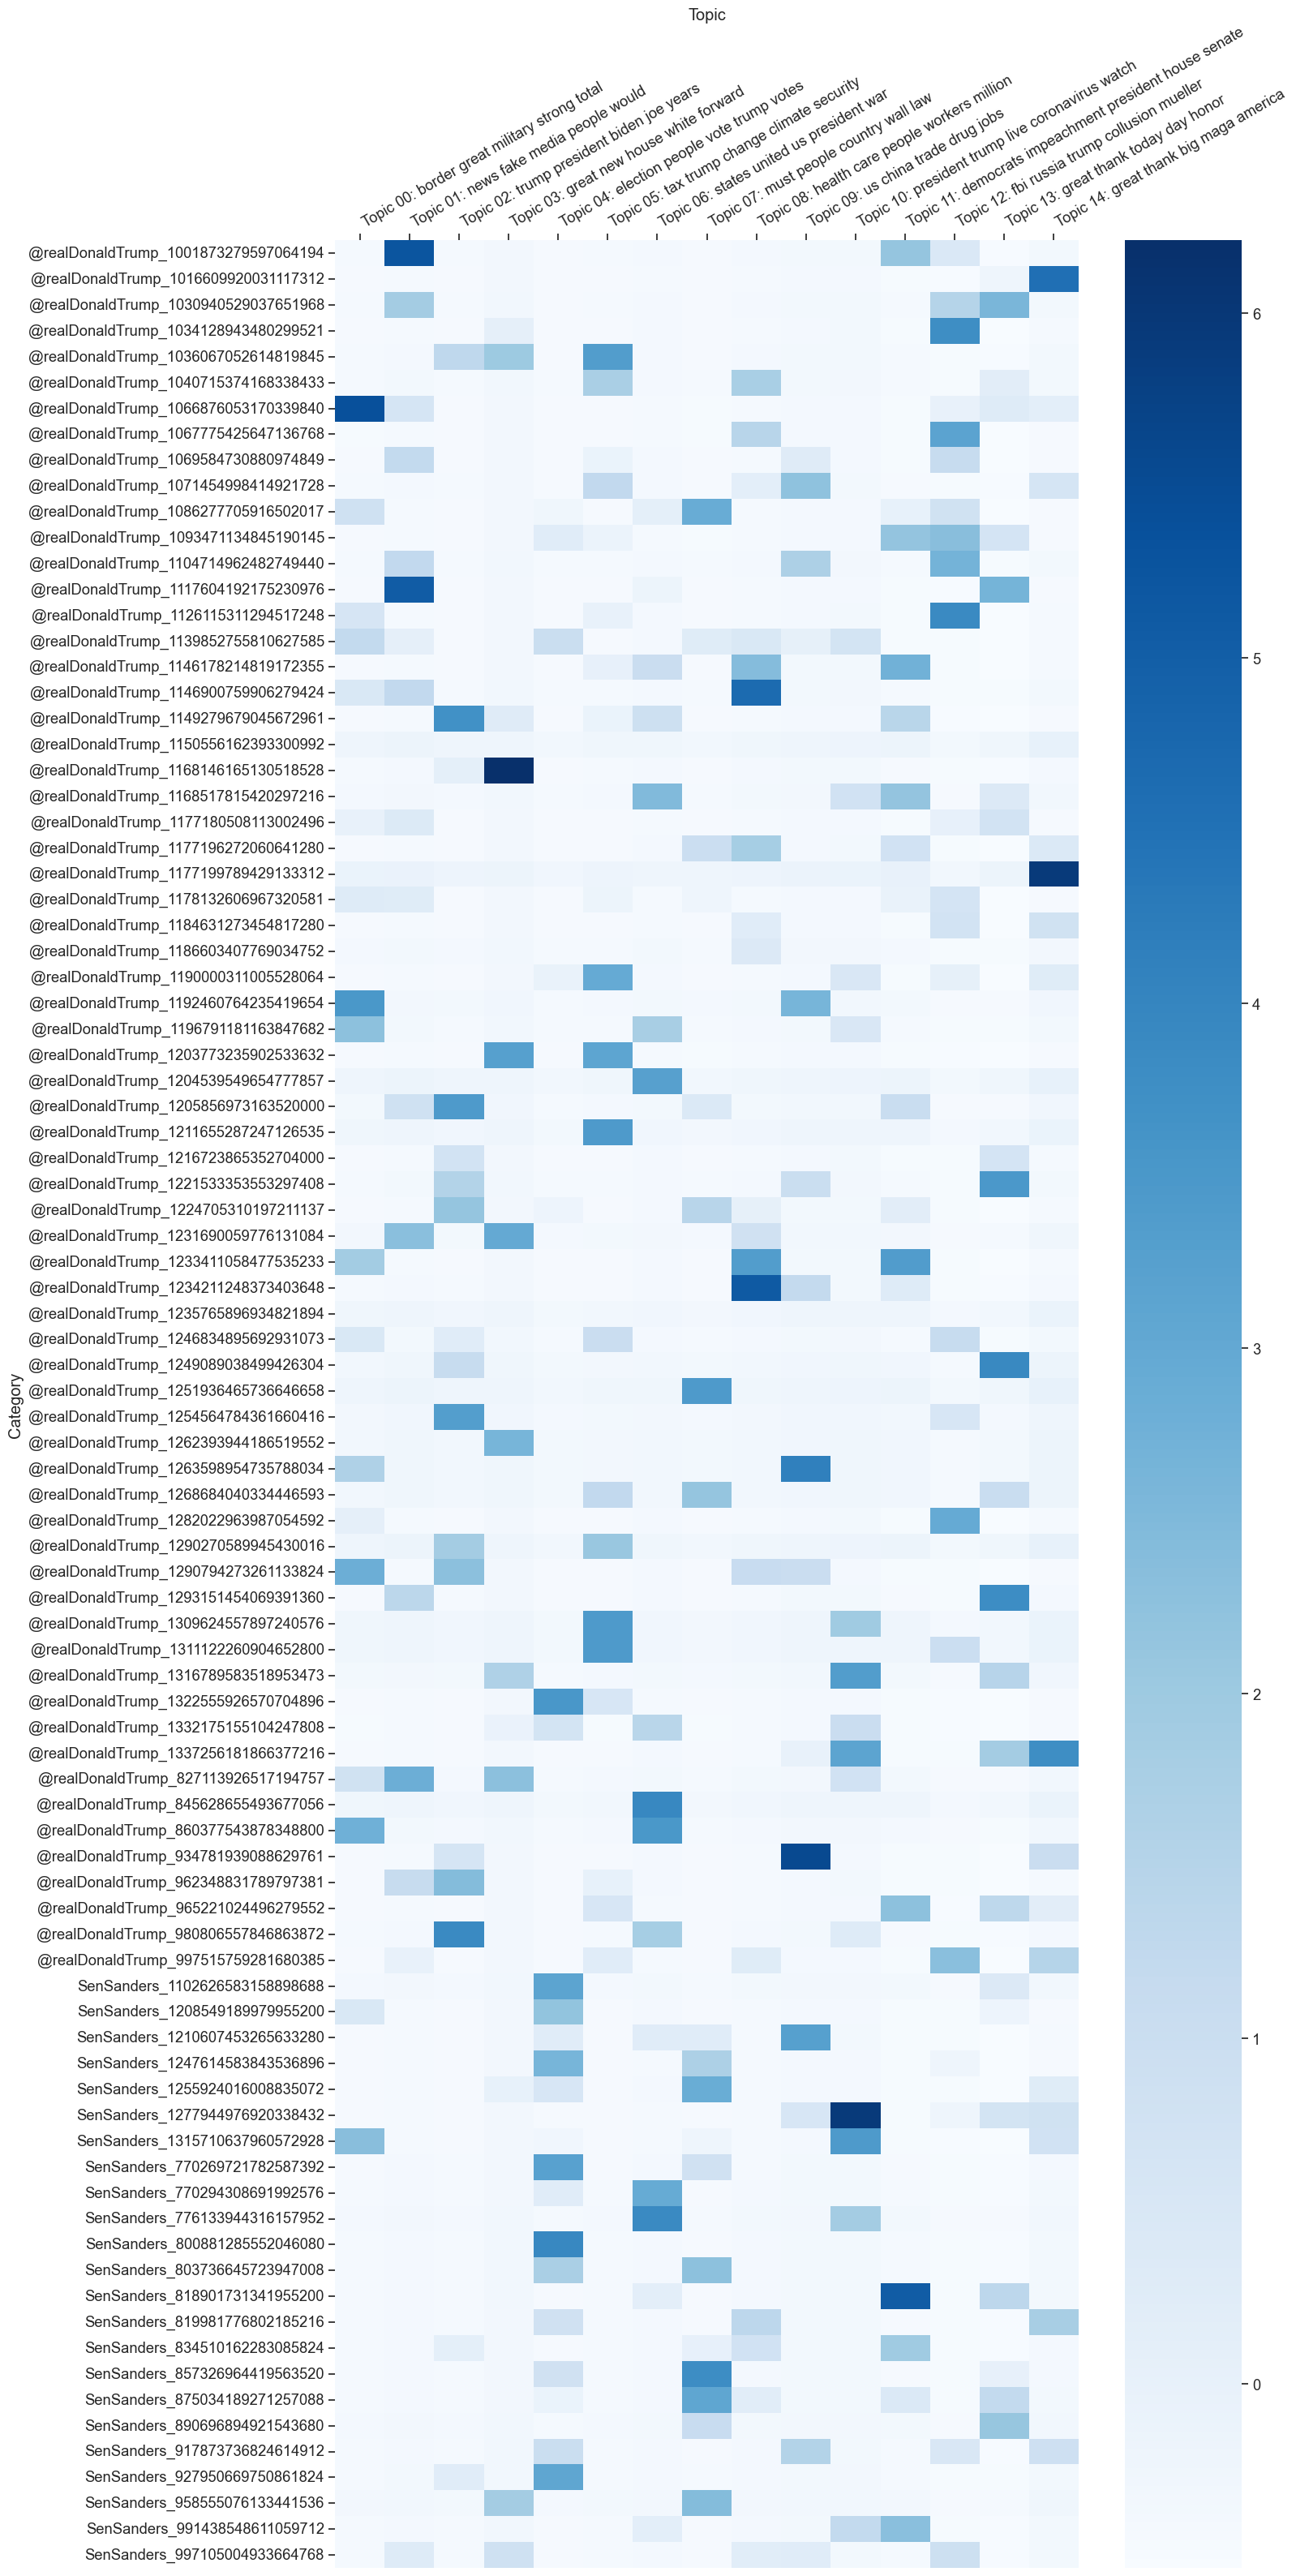

In [47]:
plot_categories_by_topics_heatmap(titles,
                                  topic_distributions,
                                  topic_individual_words,
                                  target_labels=target_labels,
                                  color_map = 'Blues',
                                 dim=(16,32))

### Q9. Interpret the heatmap
Do you see any pattern in the probability distributions of topics for each politician?

Are there topics that are more likely for one of the two politicians?

# Q9 (words)
In this heat map, the rows represent different tweets (sorted by politician), and the columns represent different topics. The color intensity of each cell indicates the probability that a particular tweet is associated with a particular topic.

Some rows display a particular concentration of darker shades in specific columns, suggesting that certain tweets have a high association with particular topics. Among the different rows associated with a particular politician's tweets, some columns were darker in color, suggesting that the politician may have frequently discussed these topics. If both politicians' tweets show darker colors on certain topics, it may indicate that they share common concerns on those topics. Trump focuses more on Topic 3, Topic 8 and Topic 14 while Sanders pays more attention to Topic 10.

However, it is difficult to grasp all the content of the tweets directly. Through the visualization of the distribution of topics, some conclusions about the likely focus of attention and discussion of the two politicians can be reached. In particular, when the distribution values for certain topics are very high, this often indicates that the corresponding tweets strongly reflect the content of that topic. In addition, since multiple tweets are included in the heatmap, patterns rather than individual data points can be observed. This can contribute to understanding overall trends rather than episodic events.

### X2. Optional question 2
(This question is not compulsory, it only allows you to get an extra point)

Make the sample balanced, with 50 tweets by Trump and 50 by Sanders.

In [48]:
# X2 (code)
from random import sample

# Select tweets from Trump and Sanders respectively
trump_tweets = [title for title, pol in zip(titles, combined_tweets['Politician']) if pol == 'Trump']
sanders_tweets = [title for title, pol in zip(titles, combined_tweets['Politician']) if pol == 'Sanders']

# Randomly select 50 tweets from each person
trump_sample = sample(trump_tweets, 50)
sanders_sample = sample(sanders_tweets, 50)

# Combine samples to get a balanced sample set
balanced_sample = trump_sample + sanders_sample

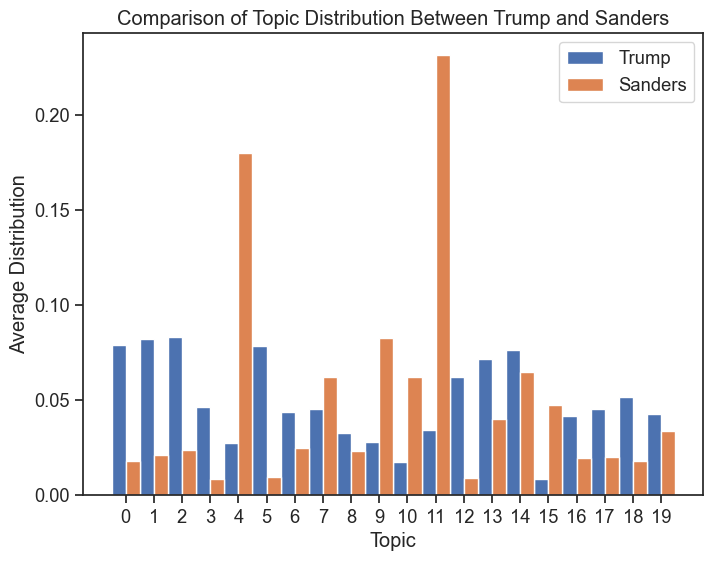

In [49]:
# Calculate topic distribution based on balanced samples
sample_distributions = [title_to_distribution[label] for label in balanced_sample if label in title_to_distribution]

sample_distributions_np = np.array(sample_distributions)

# Calculate the average topic distribution respectively
trump_distributions = sample_distributions_np[:50, :]  
sanders_distributions = sample_distributions_np[50:, :]  
mean_distributions_trump = np.mean(trump_distributions, axis=0)
mean_distributions_sanders = np.mean(sanders_distributions, axis=0)

# Plot
topics = np.arange(len(mean_distributions_trump))
bar_width = 0.5

plt.figure(figsize=(8, 6))
plt.bar(topics - bar_width/2, mean_distributions_trump, width=bar_width, label='Trump')
plt.bar(topics + bar_width/2, mean_distributions_sanders, width=bar_width, label='Sanders')

plt.xlabel('Topic')
plt.ylabel('Average Distribution')
plt.title('Comparison of Topic Distribution Between Trump and Sanders')
plt.xticks(topics)
plt.legend()
plt.show()

### X3. Optional question 3
(This question is not compulsory, it only allows you to get an extra point)

Extend the analysis to all the tweets in the dataset.

In [50]:
# X3 (code and words)
# Tip: plotting a heatmap for thousands of tweets is not practical.
# Make a comparison based on the numerical values in the `df_norm_col` dataframe (see Week 6 notebook)

topic_distributions_np = np.array(topic_distributions)

# Calculate the average of the topic distribution of Trump and Sanders' tweets
trump_indices = [i for i, title in enumerate(titles) if 'Trump' in title]
sanders_indices = [i for i, title in enumerate(titles) if 'Sanders' in title]

# Ensure index validity
valid_trump_indices = [i for i in trump_indices if i < len(topic_distributions_np)]
valid_sanders_indices = [i for i in sanders_indices if i < len(topic_distributions_np)]

# Calculate the average distribution
mean_distributions_trump = np.mean(topic_distributions_np[valid_trump_indices, :], axis=0)
mean_distributions_sanders = np.mean(topic_distributions_np[valid_sanders_indices, :], axis=0)


# Creat df_norm_col dataframe
df_norm_col = pd.DataFrame({
    'Trump': mean_distributions_trump,
    'Sanders': mean_distributions_sanders
})

# Use the topic number as the row index
df_norm_col.index = [f'Topic {i}' for i in range(1, len(mean_distributions_trump) + 1)]

# Compare the average distribution between Trump and Sanders on various topics
print(df_norm_col)

# Calculate the topics with the greatest differences
df_norm_col['Difference'] = np.abs(df_norm_col['Trump'] - df_norm_col['Sanders'])
print(df_norm_col.sort_values(by='Difference', ascending=False))

             Trump   Sanders
Topic 1   0.057752  0.023327
Topic 2   0.064190  0.025417
Topic 3   0.065758  0.020244
Topic 4   0.052836  0.011778
Topic 5   0.038688  0.194659
Topic 6   0.056884  0.023014
Topic 7   0.052469  0.030036
Topic 8   0.037017  0.087792
Topic 9   0.043261  0.033811
Topic 10  0.037236  0.063658
Topic 11  0.034326  0.063130
Topic 12  0.037643  0.132008
Topic 13  0.054744  0.018344
Topic 14  0.073477  0.040581
Topic 15  0.064276  0.046859
Topic 16  0.023394  0.049119
Topic 17  0.046847  0.025592
Topic 18  0.050587  0.030855
Topic 19  0.041768  0.037581
Topic 20  0.066843  0.042194
             Trump   Sanders  Difference
Topic 5   0.038688  0.194659    0.155971
Topic 12  0.037643  0.132008    0.094365
Topic 8   0.037017  0.087792    0.050776
Topic 3   0.065758  0.020244    0.045514
Topic 4   0.052836  0.011778    0.041058
Topic 2   0.064190  0.025417    0.038773
Topic 13  0.054744  0.018344    0.036400
Topic 1   0.057752  0.023327    0.034425
Topic 6   0.056884  0.

Topic 4 is extremely important for Sanders, with a value of 0.307235. The figure is much higher than Trump's 0.058075 with a difference of 0.249160. This indicates that Sanders' tweets focus much on this topic. Topic 13 has the smallest difference at 0.004972, indicating that Trump and Sanders paye nearly the same attention on that topic. This topic may be important or unimportant to both of them.